<a href="https://colab.research.google.com/github/ajitkumarkp/CV/blob/master/Face_smoothing_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font style = "color:rgb(50,120,229)">Face Smoothing</font>

This notebook implements a fully automated **Face Smoothing** application. 

Following are the steps:
1. Detect the face in the image using OpenCV's DNN face detection models- Caffe or TF. Even HAAR Cascades face detection model can be used.
2. Iterate over the detected faces and apply smoothing filter. 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [ ]:
# Read image
img = cv2.imread(DATA_PATH + "images/hillary_clinton.jpg")

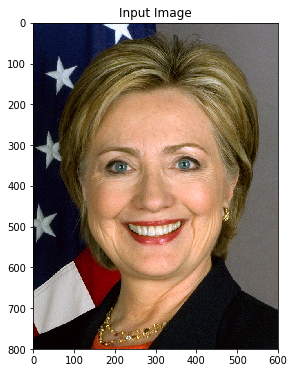

In [ ]:
plt.imshow(img[:,:,::-1])
plt.title("Input Image")
plt.show()

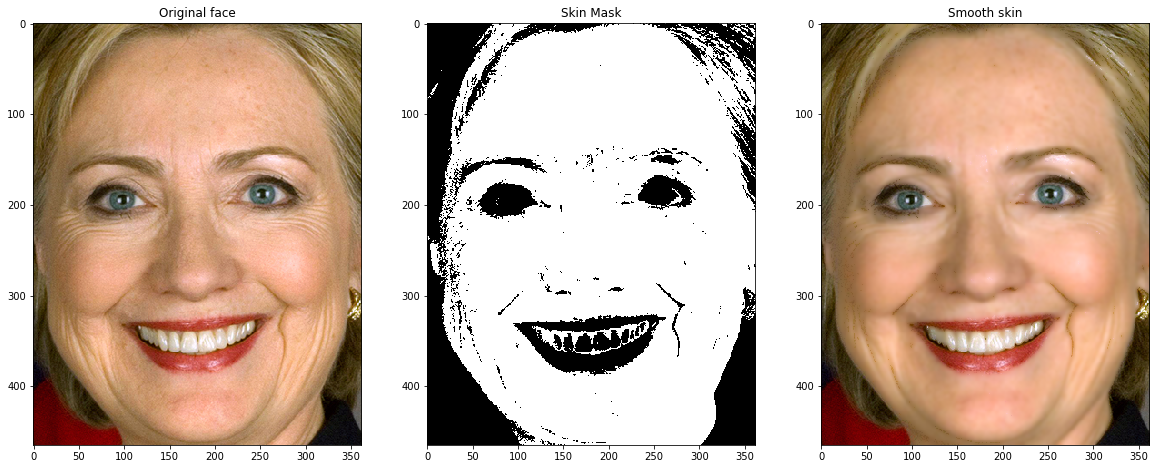

In [ ]:
DNN = "CAFFE"
if DNN == "CAFFE":
    modelFile = "resource/lib/publicdata/models/res10_300x300_ssd_iter_140000_fp16.caffemodel"
    configFile = "resource/lib/publicdata/models/deploy.prototxt"
    net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
else:
    modelFile = "resource/lib/publicdata/models/opencv_face_detector_uint8.pb"
    configFile = "resource/lib/publicdata/models/opencv_face_detector.pbtxt"
    net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)
    
def detectFaceOpenCVDnn(net, frame):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], False, False)

    net.setInput(blob)
    detections = net.forward()

    # print(detections.shape)
    bboxes = []

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
#             print(confidence)
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            # cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

conf_threshold = 0.99998
output,bboxes = detectFaceOpenCVDnn(net, img)

x1 = bboxes[0][0]
y1 = bboxes[0][1]
x2 = bboxes[0][2]
y2 = bboxes[0][3]

face = output[y1:y2, x1:x2]
smooth_face = cv2.GaussianBlur(face, (9,9), 0,0)

face_hsv = cv2.cvtColor(face, cv2.COLOR_RGB2HSV)

forehead_patch = face_hsv[120:180, 75:110]
# cv2.circle(face, (160, 96), 2, (0,0,0), -1)

min_color = np.amin(forehead_patch, axis=(0,1))
max_color = np.amax(forehead_patch, axis=(0,1))

# # plt.hist(face[...,0].ravel(),256,[0,256]) 
# # plt.show() 

min_color[2]=130
max_color[2]=255

min_color[1]=50
max_color[1]=150

# print(min_color)
# print(max_color)

skin_mask = cv2.inRange(face_hsv, min_color, max_color)

skin_mask = cv2.merge((skin_mask, skin_mask, skin_mask))

output = cv2.bitwise_and(smooth_face, skin_mask)

output2 = cv2.bitwise_and(face, cv2.bitwise_not(skin_mask))

final_output = cv2.bitwise_or(output,output2)
plt.figure(figsize=[20,12])
plt.subplot(132); plt.imshow(skin_mask); plt.title("Skin Mask")
# plt.subplot(131); plt.imshow(output2[...,::-1]); plt.title("Output2")
# plt.subplot(132); plt.imshow(output[...,::-1]); plt.title("Output")
plt.subplot(131); plt.imshow(face[...,::-1]); plt.title("Original face")
plt.subplot(133); plt.imshow(final_output[...,::-1]); plt.title("Smooth skin")
plt.show()

